In [ ]:
import requests
import pandas as pd
!pip install yfinance
import yfinance as yf
from datetime import timedelta
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

HEADERS = {"User-Agent": "homework.va2581@nyu.edu"}

# 1. Get ALL SEC filings (10-Q, 10-K) for CISCO, Goldman, and Exxon Mobil
def get_all_sec_filings(ticker):
    try:
        # get the mappings from SEC filings
        r = requests.get("https://www.sec.gov/files/company_tickers.json", headers=HEADERS)
        r.raise_for_status()
        cik_lookup = r.json()
        cik_df = pd.DataFrame(cik_lookup).T
        cik_df["ticker"] = cik_df["ticker"].str.upper()

        # Find the CIK
        cik_row = cik_df[cik_df["ticker"] == ticker.upper()]
        if cik_row.empty:
            print(f"CIK not found for {ticker}")
            return None
        cik = str(cik_row["cik_str"].values[0]).zfill(10)

        # Get ALL filings including archived
        url = f"https://data.sec.gov/submissions/CIK{cik}.json"
        r2 = requests.get(url, headers=HEADERS)
        r2.raise_for_status()
        data = r2.json()

        # first recent filings
        all_filings = pd.DataFrame(data["filings"]["recent"])

        # next archive filings (if exist)
        if "files" in data["filings"]:
            for file_info in data["filings"]["files"]:
                file_url = f"https://data.sec.gov/submissions/{file_info['name']}"
                time.sleep(0.1)
                r3 = requests.get(file_url, headers=HEADERS)
                r3.raise_for_status()
                archived_data = r3.json()
                archived_filings = pd.DataFrame(archived_data)
                all_filings = pd.concat([all_filings, archived_filings], ignore_index=True)

        # filter: only 10q and 10k
        filings = all_filings[all_filings["form"].isin(["10-Q", "10-K"])].copy()
        filings["filingDate"] = pd.to_datetime(filings["filingDate"])
        filings["ticker"] = ticker
        filings = filings.sort_values("filingDate", ascending=False)

        print(f"Found {len(filings)} total 10-Q/10-K filings for {ticker}")
        return filings

    except requests.exceptions.RequestException as e:
        print(f"Request error for {ticker}: {e}")
        return None
    except ValueError as e:
        print(f"JSON decode error for {ticker}: {e}")
        return None

def get_price_change(ticker, filing_date):
    try:
        stock = yf.Ticker(ticker)
        start = filing_date - timedelta(days=3)
        end = filing_date + timedelta(days=10)
        df = stock.history(start=start, end=end)
        if df.empty:
            return None
        df.index = pd.to_datetime(df.index)
        df = df.tz_localize(None)

        # find price at filing
        df_before = df[df.index <= filing_date]
        if df_before.empty:
            return None
        price_start = float(df_before["Close"].iloc[-1])

        # find price 7 days later
        df_after = df[df.index >= filing_date + timedelta(days=7)]
        if df_after.empty:
            return None
        price_end = float(df_after["Close"].iloc[0])

        change_percent = round((price_end - price_start) / price_start * 100, 2)
        return change_percent
    except Exception as e:
        print(f"Price fetch error for {ticker} on {filing_date.date()}: {e}")
        return None


# 3. do it for multiple companies (ALL filings)
def analyze_companies_all_time(tickers):
    all_data = []

    for ticker in tickers:

        print(f"Processing {ticker}...")


        filings = get_all_sec_filings(ticker)
        if filings is None or filings.empty:
            continue

        for idx, row in filings.iterrows():
            pct_change = get_price_change(ticker, row["filingDate"])
            all_data.append({
                "Ticker": ticker,
                "Filing Date": row["filingDate"].date(),
                "Form Type": row["form"],
                "Accession Number": row["accessionNumber"],
                "PriceChange_%": pct_change
            })


            if (idx + 1) % 10 == 0:
                print(f"  Processed {idx + 1}/{len(filings)} filings...")

        time.sleep(0.2)

    df = pd.DataFrame(all_data)
    df.sort_values(by=["Ticker", "Filing Date"], ascending=[True, False], inplace=True)
    return df

# 4. run analysis for all 3 companies
tickers = ["GS", "CSCO", "XOM"]

print(f"Companies: {', '.join(tickers)}")


result_df = analyze_companies_all_time(tickers)

# display stats

print(" ALL TIME SEC Filing Price Change Analysis")

from IPython.display import display
display(result_df)

# statistics
print("Summary by Company")
summary = result_df.groupby("Ticker").agg({
    "Filing Date": "count",
    "PriceChange_%": ["mean", "median", "std"]
}).round(2)
summary.columns = ["Total Filings", "Avg Price Change %", "Median Price Change %", "Std Dev %"]
display(summary)

# Save CSV
result_df.to_csv("sec_filings_alltime_analysis.csv", index=False)
print("\nSaved to 'sec_filings_alltime_analysis.csv'")

Companies: GS, CSCO, XOM
Processing GS...
Found 103 total 10-Q/10-K filings for GS
  Processed 3970/103 filings...
  Processed 14290/103 filings...
  Processed 30130/103 filings...
  Processed 44410/103 filings...
  Processed 53020/103 filings...
  Processed 57890/103 filings...
  Processed 61460/103 filings...
  Processed 68670/103 filings...
  Processed 69510/103 filings...
  Processed 75300/103 filings...
  Processed 76220/103 filings...
  Processed 76700/103 filings...
  Processed 76920/103 filings...
Processing CSCO...
Found 122 total 10-Q/10-K filings for CSCO
  Processed 860/122 filings...
  Processed 1300/122 filings...
  Processed 1470/122 filings...
  Processed 2210/122 filings...
  Processed 2460/122 filings...
  Processed 2520/122 filings...
  Processed 2780/122 filings...
  Processed 2880/122 filings...
  Processed 3010/122 filings...
  Processed 3250/122 filings...
  Processed 3330/122 filings...
Processing XOM...
Found 125 total 10-Q/10-K filings for XOM
  Processed 1310

,Ticker,Filing Date,Form Type,Accession Number,PriceChange_%
103,CSCO,2025-09-03,10-K,0000858877-25-000111,0.68
104,CSCO,2025-05-20,10-Q,0000858877-25-000033,0.52
105,CSCO,2025-02-18,10-Q,0000858877-25-000007,-0.50
106,CSCO,2024-11-19,10-Q,0000858877-24-000030,4.53
107,CSCO,2024-09-05,10-K,0000858877-24-000017,0.98
...,...,...,...,...,...
345,XOM,1995-03-10,10-K,0000950109-95-000647,0.38
346,XOM,1994-11-14,10-Q,0000034088-94-000008,1.05
347,XOM,1994-08-15,10-Q,0000034088-94-000003,-1.04
348,XOM,1994-05-11,10-Q,0000034088-94-000002,0.61


Summary by Company


,Total Filings,Avg Price Change %,Median Price Change %,Std Dev %
Ticker,,,,
CSCO,122,-0.27,-0.04,4.44
GS,103,0.08,-0.12,5.04
XOM,125,0.19,-0.02,2.85



Saved to 'sec_filings_alltime_analysis.csv'


In [ ]:

from IPython.display import display
# Goldman years surpsise estimates
spreadsheet_id = '1QAKETyg58dcvgq6Cg1v5UCR5IoPTUCQR'
gid = '1639492175'
csv_url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url, low_memory=False)
GS_yearly_df = df


# goldman quarters suprise estimates
spreadsheet_id = '1i850lAcpWU4mkBqD2jY-LJwW2_Eci9CU'
gid = '1639492175'
csv_url1 = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url1, low_memory=False)
GS_quarterly_df = df


# exxon years surprise estimates
spreadsheet_id = '1PINbywZmMILxWKrRJ-Di8J2eDE82ESCX'
gid = '951701505'
csv_url2 = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url2, low_memory=False)
XOM_yearly_df = df

# exxon quarters suprise estimates
spreadsheet_id = '1D_OB2ZpSG9iUB_9n9KUaZkILEGYV7gV0'
gid = '951701505'
csv_url3 = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url3, low_memory=False)
XOM_quarterly_df = df

# csco years surprise estimates
spreadsheet_id = '1gLx9Gtd1XlsV4YJKKLGKUHZmgxSZfTHF'
gid = '1162731175'
csv_url4 = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url4, low_memory=False)
CSCO_yearly_df = df


# csco quarters surprise estimates
spreadsheet_id = '1BnXpg_ho5Nt9Ly2Kf45ePwT-FoiIxL_-'
gid = '1162731175'
csv_url5 = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}'
df = pd.read_csv(csv_url5, low_memory=False)
CSCO_quarterly_df = df


In [ ]:
GS_yearly_df = pd.read_csv(csv_url, low_memory=False)

# Assign a descriptive title
GS_yearly_df.attrs["title"] = "Goldman Sachs Fiscal Yearly Surprise Estimates"

# EPS Announced Date
eps_announced_row = GS_yearly_df[
    GS_yearly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]

# Extract the release dates (skip the first column)
release_dates = eps_announced_row[1:].values

# Set the first row as column headers
GS_yearly_df.columns = GS_yearly_df.iloc[0, :]
GS_yearly_df = GS_yearly_df.drop(index=0)

# each release date becomes a row
GS_yearly_df = GS_yearly_df.T

# first row becomes the column headers (like EPS, Revenu...)
GS_yearly_df.columns = GS_yearly_df.iloc[0]
GS_yearly_df = GS_yearly_df.drop(index=GS_yearly_df.index[0])

#the release dates as index
GS_yearly_df.index = release_dates

# Clean up index
GS_yearly_df.index.name = "Release Date"
GS_yearly_df.index = pd.to_datetime(GS_yearly_df.index, errors="coerce")

# --- Final display ---
print(f"\nTitle: {GS_yearly_df.attrs['title']}")
print(f"Shape: {GS_yearly_df.shape}")
print(f"Index name: {GS_yearly_df.index.name}")
GS_yearly_df


Title: Goldman Sachs Fiscal Yearly Surprise Estimates
Shape: (20, 11)
Index name: Release Date


NYSE:GS (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2004-12-16,0.34%,0.03,8.92 A,8.89 E,Dec-16-2004,2004,(0.80%),( 165.62),"20,550.00 A","20,715.62 E",Dec-16-2004
2005-12-15,(1.67%),( 0.19),11.21 A,11.40 E,Dec-15-2005,2005,0.81%,198.69,"24,782.00 A","24,583.31 E",Dec-15-2005
2006-12-12,0.46%,0.09,19.69 A,19.60 E,Dec-12-2006,2006,2.13%,786.57,"37,665.00 A","36,878.43 E",Dec-12-2006
2007-12-18,1.19%,0.29,24.73 A,24.44 E,Dec-18-2007,2007,1.42%,643.58,"45,987.00 A","45,343.42 E",Dec-18-2007
2010-01-21,16.66%,3.16,22.13 A,18.97 E,Jan-21-2010,2009,(0.35%),( 158.24),"45,173.00 A","45,331.24 E",Jan-21-2010
2011-01-19,0.08%,0.01,13.18 A,13.17 E,Jan-19-2011,2010,0.25%,98.34,"39,161.00 A","39,062.66 E",Jan-19-2011
2012-01-18,8.15%,0.34,4.51 A,4.17 E,Jan-18-2012,2011,(0.84%),( 242.92),"28,811.00 A","29,053.92 E",Jan-18-2012
2013-01-16,17.46%,2.1,14.13 A,12.03 E,Jan-16-2013,2012,4.22%,"1,382.52","34,163.00 A","32,780.48 E",Jan-16-2013
2014-01-16,3.41%,0.51,15.46 A,14.95 E,Jan-16-2014,2013,3.17%,"1,049.47","34,206.00 A","33,156.53 E",Jan-16-2014


In [ ]:
#Same format as previous data frame
GS_quarterly_df = pd.read_csv(csv_url1, low_memory=False)


GS_quarterly_df.attrs["title"] = "Goldman Sachs Fiscal Quarterly Surprise Estimates"


eps_announced_row = GS_quarterly_df[
    GS_quarterly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]


release_dates = eps_announced_row[1:].values


GS_quarterly_df.columns = GS_quarterly_df.iloc[0, :]
GS_quarterly_df = GS_quarterly_df.drop(index=0)


GS_quarterly_df = GS_quarterly_df.T


GS_quarterly_df.columns = GS_quarterly_df.iloc[0]
GS_quarterly_df = GS_quarterly_df.drop(index=GS_quarterly_df.index[0])


GS_quarterly_df.index = release_dates


GS_quarterly_df.index.name = "Release Date"
GS_quarterly_df.index = pd.to_datetime(GS_quarterly_df.index, errors="coerce")


print(f"\nTitle: {GS_quarterly_df.attrs['title']}")
print(f"Shape: {GS_quarterly_df.shape}")
print(f"Index name: {GS_quarterly_df.index.name}")
GS_quarterly_df


Title: Goldman Sachs Fiscal Quarterly Surprise Estimates
Shape: (84, 11)
Index name: Release Date


NYSE:GS (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2004-09-21,20.83%,0.3,1.74 A,1.44 E,Sep-21-2004,FQ3 2004 - Aug 2004,9.51%,393.43,"4,530.00 A","4,136.57 E",Sep-21-2004
2004-12-16,0.00%,-,2.36 A,2.36 E,Dec-16-2004,FQ4 2004 - Nov 2004,(3.55%),( 168.82),"4,581.00 A","4,749.82 E",Dec-16-2004
2005-03-17,33.64%,0.74,2.94 A,2.20 E,Mar-17-2005,FQ1 2005 - Feb 2005,17.32%,945.43,"6,405.00 A","5,459.57 E",Mar-17-2005
2005-06-16,(7.57%),( 0.14),1.71 A,1.85 E,Jun-16-2005,FQ2 2005 - May 2005,(1.22%),( 59.17),"4,806.00 A","4,865.17 E",Jun-16-2005
2005-09-20,38.30%,0.9,3.25 A,2.35 E,Sep-20-2005,FQ3 2005 - Aug 2005,24.99%,"1,456.33","7,285.00 A","5,828.67 E",Sep-20-2005
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,21.39%,1.48,8.40 A,6.92 E,Oct-15-2024,FQ3 2024 - Sep 2024,8.01%,941.84,"12,699.00 A","11,757.16 E",Oct-15-2024
2025-01-15,43.11%,3.6,11.95 A,8.35 E,Jan-15-2025,FQ4 2024 - Dec 2024,11.28%,"1,405.92","13,869.00 A","12,463.08 E",Jan-15-2025
2025-04-14,15.17%,1.86,14.12 A,12.26 E,Apr-14-2025,FQ1 2025 - Mar 2025,2.38%,350.6,"15,062.00 A","14,711.40 E",Apr-14-2025


In [ ]:
#Same format as previous data frame
XOM_yearly_df = pd.read_csv(csv_url2, low_memory=False)


XOM_yearly_df.attrs["title"] = "ExxonMobil Fiscal Yearly Surprise Estimates"


eps_announced_row = XOM_yearly_df[
    XOM_yearly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]


release_dates = eps_announced_row[1:].values


XOM_yearly_df.columns = XOM_yearly_df.iloc[0, :]
XOM_yearly_df = XOM_yearly_df.drop(index=0)


XOM_yearly_df = XOM_yearly_df.T


XOM_yearly_df.columns = XOM_yearly_df.iloc[0]
XOM_yearly_df = XOM_yearly_df.drop(index=XOM_yearly_df.index[0])


XOM_yearly_df.index = release_dates


XOM_yearly_df.index.name = "Release Date"
XOM_yearly_df.index = pd.to_datetime(XOM_yearly_df.index, errors="coerce")


print(f"\nTitle: {XOM_yearly_df.attrs['title']}")
print(f"Shape: {XOM_yearly_df.shape}")
print(f"Index name: {XOM_yearly_df.index.name}")
XOM_yearly_df


Title: ExxonMobil Fiscal Yearly Surprise Estimates
Shape: (20, 11)
Index name: Release Date


NYSE:XOM (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2006-01-30,5.55%,0.3,5.71 A,5.41 E,Jan-30-2006,2005,(4.42%),"( 17,163.5)","370,998.00 A","388,161.50 E",Jan-30-2006
2007-02-01,4.75%,0.3,6.62 A,6.32 E,Feb-01-2007,2006,(15.63%),"( 69,980.33)","377,635.00 A","447,615.33 E",Feb-01-2007
2008-02-01,4.15%,0.29,7.28 A,6.99 E,Feb-01-2008,2007,(1.95%),"( 8,061.62)","404,552.00 A","412,613.62 E",Feb-01-2008
2009-01-30,2.48%,0.21,8.69 A,8.48 E,Jan-30-2009,2008,4.48%,"20,474.0","477,359.00 A","456,885.00 E",Jan-30-2009
2010-02-01,1.79%,0.07,3.98 A,3.91 E,Feb-01-2010,2009,1.38%,"4,242.41","310,586.00 A","306,343.59 E",Feb-01-2010
2011-01-31,4.19%,0.25,6.22 A,5.97 E,Jan-31-2011,2010,(2.29%),"( 8,971.89)","383,221.00 A","392,192.89 E",Jan-31-2011
2012-01-31,(0.36%),( 0.03),8.42 A,8.45 E,Jan-31-2012,2011,0.65%,"3,135.18","486,429.00 A","483,293.82 E",Jan-31-2012
2013-02-01,1.68%,0.16,9.70 A,9.54 E,Feb-01-2013,2012,2.11%,"9,949.3","482,295.00 A","472,345.70 E",Feb-01-2013
2014-01-30,(0.67%),( 0.05),7.37 A,7.42 E,Jan-30-2014,2013,(1.55%),"( 6,913.95)","438,255.00 A","445,168.95 E",Jan-30-2014


In [ ]:
#Same format as previous data frame
XOM_quarterly_df = pd.read_csv(csv_url3, low_memory=False)


XOM_quarterly_df.attrs["title"] = "ExxonMobil Fiscal Quarterly Surprise Estimates"


eps_announced_row = XOM_quarterly_df[
    XOM_quarterly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]


release_dates = eps_announced_row[1:].values


XOM_quarterly_df.columns = XOM_quarterly_df.iloc[0, :]
XOM_quarterly_df = XOM_quarterly_df.drop(index=0)


XOM_quarterly_df = XOM_quarterly_df.T


XOM_quarterly_df.columns = XOM_quarterly_df.iloc[0]
XOM_quarterly_df = XOM_quarterly_df.drop(index=XOM_quarterly_df.index[0])


XOM_quarterly_df.index = release_dates


XOM_quarterly_df.index.name = "Release Date"
XOM_quarterly_df.index = pd.to_datetime(XOM_quarterly_df.index, errors="coerce")


print(f"\nTitle: {XOM_quarterly_df.attrs['title']}")
print(f"Shape: {XOM_quarterly_df.shape}")
print(f"Index name: {XOM_quarterly_df.index.name}")
XOM_quarterly_df


Title: ExxonMobil Fiscal Quarterly Surprise Estimates
Shape: (79, 11)
Index name: Release Date


NYSE:XOM (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2006-01-30,15.54%,0.23,1.71 A,1.48 E,Jan-30-2006,FQ4 2005 - Dec 2005,(1.61%),"( 1,629.74)","99,662.00 A","101,291.74 E",Jan-30-2006
2006-04-27,(6.80%),( 0.1),1.37 A,1.47 E,Apr-27-2006,FQ1 2006 - Mar 2006,(4.95%),"( 4,636.99)","88,980.00 A","93,616.99 E",Apr-27-2006
2006-07-27,2.38%,0.04,1.72 A,1.68 E,Jul-27-2006,FQ2 2006 - Jun 2006,(5.01%),"( 5,221.48)","99,034.00 A","104,255.48 E",Jul-27-2006
2006-10-26,7.27%,0.12,1.77 A,1.65 E,Oct-26-2006,FQ3 2006 - Sep 2006,1.83%,"1,788.44","99,593.00 A","97,804.56 E",Oct-26-2006
2007-02-01,19.73%,0.29,1.76 A,1.47 E,Feb-01-2007,FQ4 2006 - Dec 2006,(9.97%),"( 9,972.0)","90,028.00 A","100,000.00 E",Feb-01-2007
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02,5.42%,0.11,2.14 A,2.03 E,Aug-02-2024,FQ2 2024 - Jun 2024,3.77%,"3,378.59","93,060.00 A","89,681.41 E",Aug-02-2024
2024-11-01,2.13%,0.04,1.92 A,1.88 E,Nov-01-2024,FQ3 2024 - Sep 2024,1.87%,"1,655.48","90,016.00 A","88,360.52 E",Nov-01-2024
2025-01-31,10.97%,0.17,1.72 A,1.55 E,Jan-31-2025,FQ4 2024 - Dec 2024,(4.32%),"( 3,769.88)","83,426.00 A","87,195.88 E",Jan-31-2025


In [ ]:
#Same format as previous data frame
CSCO_yearly_df = pd.read_csv(csv_url4, low_memory=False)


CSCO_yearly_df.attrs["title"] = "Cisco Fiscal Yearly Surprise Estimates"


eps_announced_row = CSCO_yearly_df[
    CSCO_yearly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]


release_dates = eps_announced_row[1:].values


CSCO_yearly_df.columns = CSCO_yearly_df.iloc[0, :]
CSCO_yearly_df = CSCO_yearly_df.drop(index=0)


CSCO_yearly_df = CSCO_yearly_df.T


CSCO_yearly_df.columns = CSCO_yearly_df.iloc[0]
CSCO_yearly_df = CSCO_yearly_df.drop(index=CSCO_yearly_df.index[0])


CSCO_yearly_df.index = release_dates


CSCO_yearly_df.index.name = "Release Date"
CSCO_yearly_df.index = pd.to_datetime(CSCO_yearly_df.index, errors="coerce")


print(f"\nTitle: {CSCO_yearly_df.attrs['title']}")
print(f"Shape: {CSCO_yearly_df.shape}")
print(f"Index name: {CSCO_yearly_df.index.name}")
CSCO_yearly_df


Title: Cisco Fiscal Yearly Surprise Estimates
Shape: (22, 11)
Index name: Release Date


NasdaqGS:CSCO (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2004-08-10,(1.59%),( 0.01),0.62 A,0.63 E,Aug-10-2004,2004,0.15%,33.27,"22,045.00 A","22,011.73 E",Aug-10-2004
2005-08-09,0.00%,-,0.87 A,0.87 E,Aug-09-2005,2005,0.09%,21.08,"24,801.00 A","24,779.92 E",Aug-09-2005
2006-08-08,0.00%,-,0.89 A,0.89 E,Aug-08-2006,2006,0.29%,80.99,"28,484.00 A","28,403.01 E",Aug-08-2006
2007-08-07,(1.68%),( 0.02),1.17 A,1.19 E,Aug-07-2007,2007,0.55%,191.38,"34,922.00 A","34,730.62 E",Aug-07-2007
2008-08-05,0.00%,-,1.31 A,1.31 E,Aug-05-2008,2008,0.11%,45.33,"39,540.00 A","39,494.67 E",Aug-05-2008
2009-08-05,(4.55%),( 0.05),1.05 A,1.10 E,Aug-05-2009,2009,0.05%,19.07,"36,117.00 A","36,097.93 E",Aug-05-2009
2010-08-11,(0.75%),( 0.01),1.33 A,1.34 E,Aug-11-2010,2010,(0.11%),( 43.78),"40,040.00 A","40,083.78 E",Aug-11-2010
2011-08-10,0.86%,0.01,1.17 A,1.16 E,Aug-10-2011,2011,0.53%,227.35,"43,218.00 A","42,990.65 E",Aug-10-2011
2012-08-15,(1.32%),( 0.02),1.49 A,1.51 E,Aug-15-2012,2012,0.21%,94.55,"46,061.00 A","45,966.45 E",Aug-15-2012


In [ ]:
#Same format as previous data frame
CSCO_quarterly_df = pd.read_csv(csv_url5, low_memory=False)


CSCO_quarterly_df.attrs["title"] = "Cisco Fiscal Quarterly Surprise Estimates"


eps_announced_row = CSCO_quarterly_df[
    CSCO_quarterly_df.iloc[:, 0].str.contains("EPS Announced Date", na=False)
].iloc[0]


release_dates = eps_announced_row[1:].values


CSCO_quarterly_df.columns = CSCO_quarterly_df.iloc[0, :]
CSCO_quarterly_df = CSCO_quarterly_df.drop(index=0)


CSCO_quarterly_df = CSCO_quarterly_df.T


CSCO_quarterly_df.columns = CSCO_quarterly_df.iloc[0]
CSCO_quarterly_df = CSCO_quarterly_df.drop(index=CSCO_quarterly_df.index[0])


CSCO_quarterly_df.index = release_dates


CSCO_quarterly_df.index.name = "Release Date"
CSCO_quarterly_df.index = pd.to_datetime(CSCO_quarterly_df.index, errors="coerce")


print(f"\nTitle: {CSCO_quarterly_df.attrs['title']}")
CSCO_quarterly_df


Title: Cisco Fiscal Quarterly Surprise Estimates


NasdaqGS:CSCO (USD),EPS (GAAP),EPS Difference,EPS Actual,EPS Estimate,EPS Announced Date,Company Level (USD),Revenue,Revenue Difference,Revenue Actual,Revenue Estimate,Revenue Announced Date
Release Date,,,,,,,,,,,
2004-08-10,11.11%,0.02,0.20 A,0.18 E,Aug-10-2004,FQ4 2004 - Jul 2004,0.64%,37.44,"5,926.00 A","5,888.56 E",Aug-10-2004
2004-11-09,5.00%,0.01,0.21 A,0.20 E,Nov-09-2004,FQ1 2005 - Oct 2004,(0.80%),( 48.36),"5,971.00 A","6,019.36 E",Nov-09-2004
2005-02-08,5.00%,0.01,0.21 A,0.20 E,Feb-08-2005,FQ2 2005 - Jan 2005,(1.02%),( 62.16),"6,062.00 A","6,124.16 E",Feb-08-2005
2005-05-10,0.00%,-,0.21 A,0.21 E,May-10-2005,FQ3 2005 - Apr 2005,0.55%,33.94,"6,187.00 A","6,153.06 E",May-10-2005
2005-08-09,4.35%,0.01,0.24 A,0.23 E,Aug-09-2005,FQ4 2005 - Jul 2005,0.38%,24.67,"6,581.00 A","6,556.33 E",Aug-09-2005
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-14,5.88%,0.03,0.54 A,0.51 E,Aug-14-2024,FQ4 2024 - Jul 2024,0.78%,106.2,"13,642.00 A","13,535.80 E",Aug-14-2024
2024-11-13,51.11%,0.23,0.68 A,0.45 E,Nov-13-2024,FQ1 2025 - Oct 2024,0.51%,70.49,"13,841.00 A","13,770.51 E",Nov-13-2024
2025-02-12,8.93%,0.05,0.61 A,0.56 E,Feb-12-2025,FQ2 2025 - Jan 2025,0.84%,117.01,"13,991.00 A","13,873.99 E",Feb-12-2025


Total rows after price fetch: 310


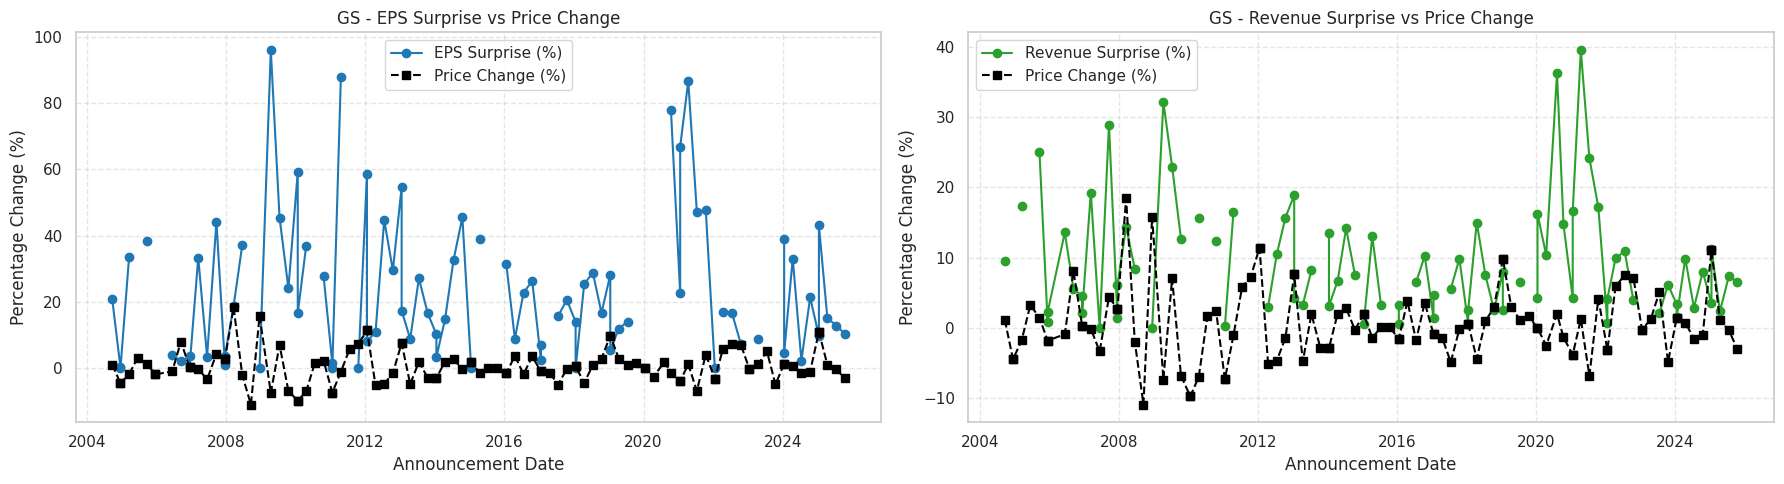

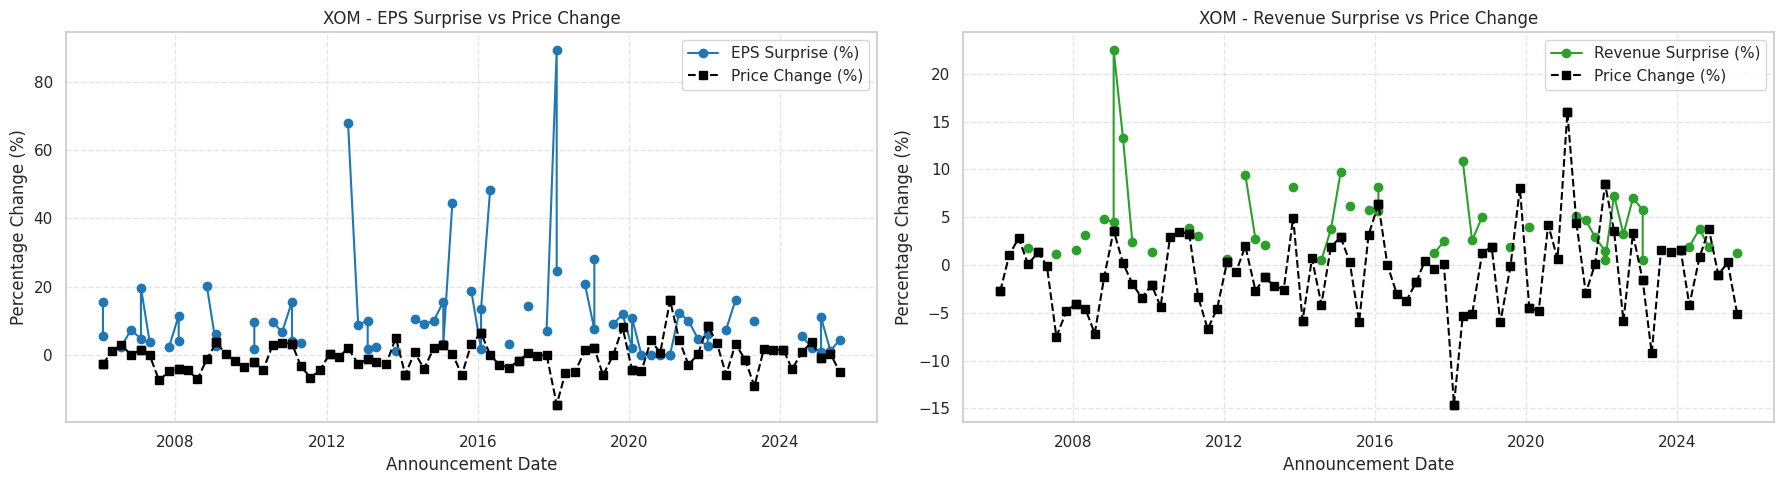

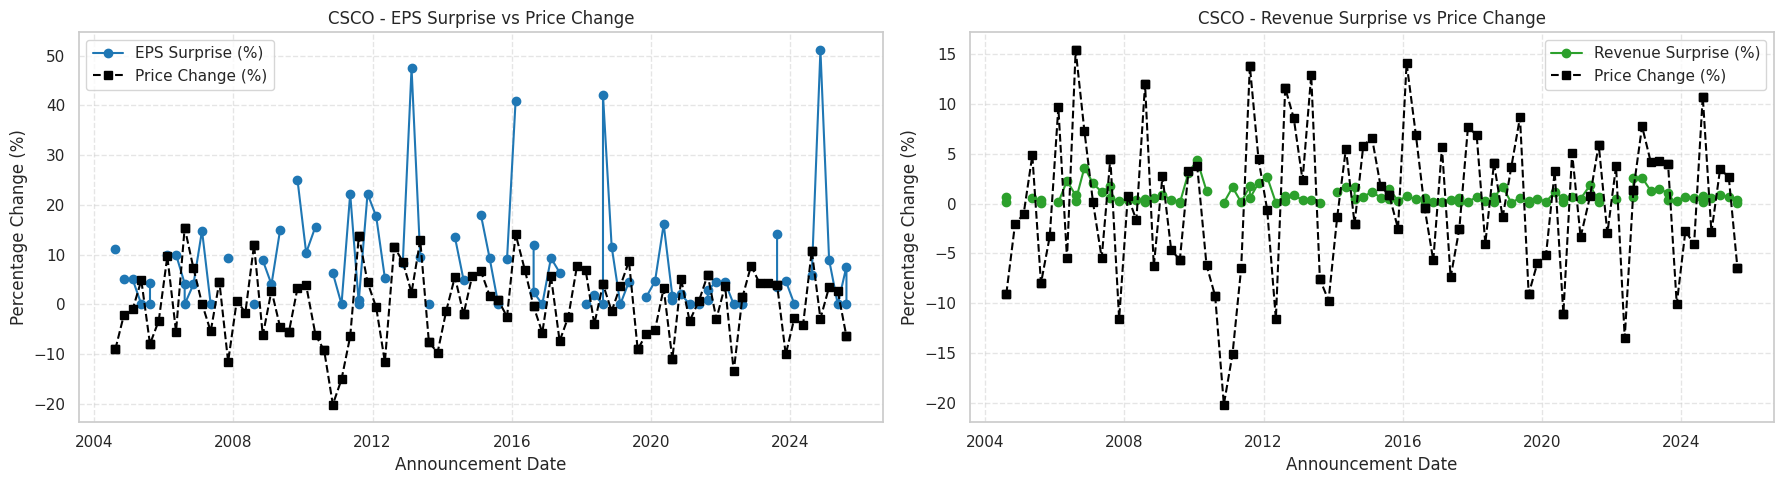

In [ ]:
from datetime import timedelta
import matplotlib.pyplot as plt

#surprise spreadsheet
def clean_surprise_df(df, ticker, period_type):
    """
    Cleans up and standardizes a surprise spreadsheet using EPS and Revenue columns.
    """
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    #  EPS and Revenue columns
    eps_col = next((c for c in df.columns if "EPS" in c), None)
    rev_col = next((c for c in df.columns if "Revenue" in c), None)

    # Set announcement dates from index
    df["Announce_Date"] = pd.to_datetime(df.index, errors="coerce")

    clean = pd.DataFrame({
        "Ticker": ticker,
        "Period Type": period_type,
        "Announce_Date": df["Announce_Date"],
        "EPS_Surprise": pd.to_numeric(df[eps_col].astype(str).str.replace("%","",regex=False), errors="coerce") if eps_col else np.nan,
        "Revenue_Surprise": pd.to_numeric(df[rev_col].astype(str).str.replace("%","",regex=False), errors="coerce") if rev_col else np.nan
    })

    return clean


#calc price change using yfinanc
def compute_price_change_yf(df, days_before=1, days_after=7):
    """
    Calculate price change around EPS announcement dates using yfinance.
    """
    df = df.copy()
    df["PriceChange_%"] = None

    for idx, row in df.iterrows():
        tkr = row["Ticker"]
        eps_date = row["Announce_Date"]
        if pd.isna(eps_date):
            continue

        start = eps_date - timedelta(days=days_before)
        end = eps_date + timedelta(days=days_after)

        try:
            stock = yf.Ticker(tkr)
            hist = stock.history(start=start, end=end)
            if hist.empty:
                continue

            start_price = hist["Close"].iloc[0]
            end_price = hist["Close"].iloc[-1]

            pct_change = (end_price - start_price) / start_price * 100
            df.at[idx, "PriceChange_%"] = pct_change

        except Exception as e:
            print(f"Error fetching price for {tkr} on {eps_date}: {e}")

    return df



#Plot EPS and Revenue vs Price side by side
def plot_surprise_vs_price_side_by_side(df):
    for tkr in df["Ticker"].unique():
        sub = df[df["Ticker"] == tkr].sort_values("Announce_Date")

        fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

        # EPS vs Price
        axes[0].plot(sub["Announce_Date"], sub["EPS_Surprise"], marker="o", label="EPS Surprise (%)", color="tab:blue")
        axes[0].plot(sub["Announce_Date"], sub["PriceChange_%"], marker="s", linestyle="--", label="Price Change (%)", color="black")
        axes[0].set_title(f"{tkr} - EPS Surprise vs Price Change")
        axes[0].set_xlabel("Announcement Date")
        axes[0].set_ylabel("Percentage Change (%)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", alpha=0.5)

        # Revenue vs Price
        axes[1].plot(sub["Announce_Date"], sub["Revenue_Surprise"], marker="o", label="Revenue Surprise (%)", color="tab:green")
        axes[1].plot(sub["Announce_Date"], sub["PriceChange_%"], marker="s", linestyle="--", label="Price Change (%)", color="black")
        axes[1].set_title(f"{tkr} - Revenue Surprise vs Price Change")
        axes[1].set_xlabel("Announcement Date")
        axes[1].set_ylabel("Percentage Change (%)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()



#Load and clean surprise sheets for all companies
all_surprise_df = pd.concat([
    clean_surprise_df(GS_quarterly_df, "GS", "Quarterly"),
    clean_surprise_df(GS_yearly_df, "GS", "Yearly"),
    clean_surprise_df(XOM_quarterly_df, "XOM", "Quarterly"),
    clean_surprise_df(XOM_yearly_df, "XOM", "Yearly"),
    clean_surprise_df(CSCO_quarterly_df, "CSCO", "Quarterly"),
    clean_surprise_df(CSCO_yearly_df, "CSCO", "Yearly")
], ignore_index=True)

#Compute price changes
merged_with_prices = compute_price_change_yf(all_surprise_df, days_before=1, days_after=7)
print(f"Total rows after price fetch: {len(merged_with_prices)}")



#Plot EPS and Revenue vs Price side by side
plot_surprise_vs_price_side_by_side(merged_with_prices)


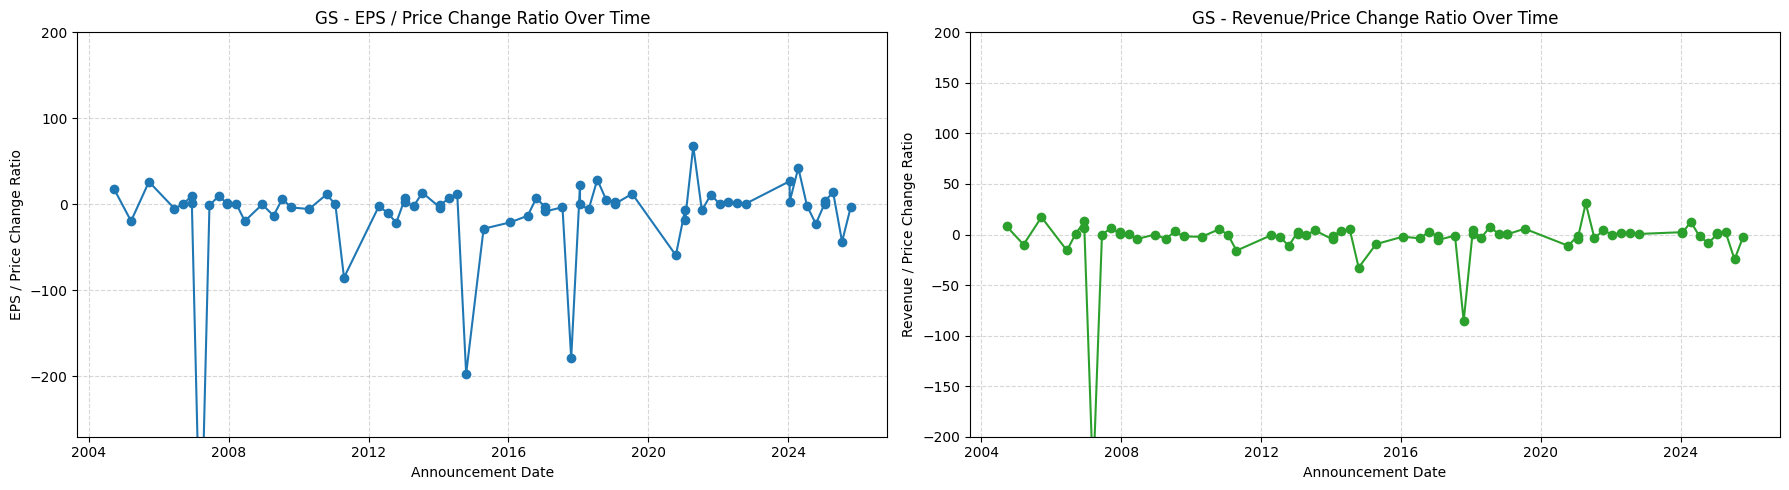

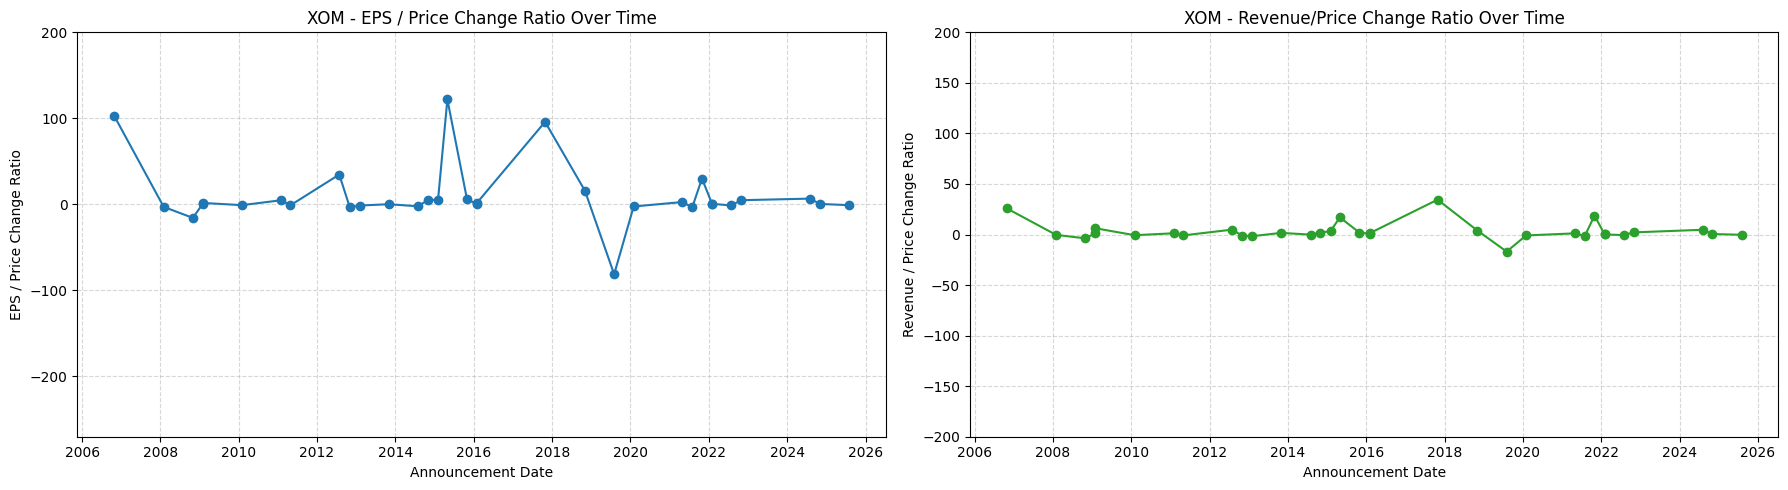

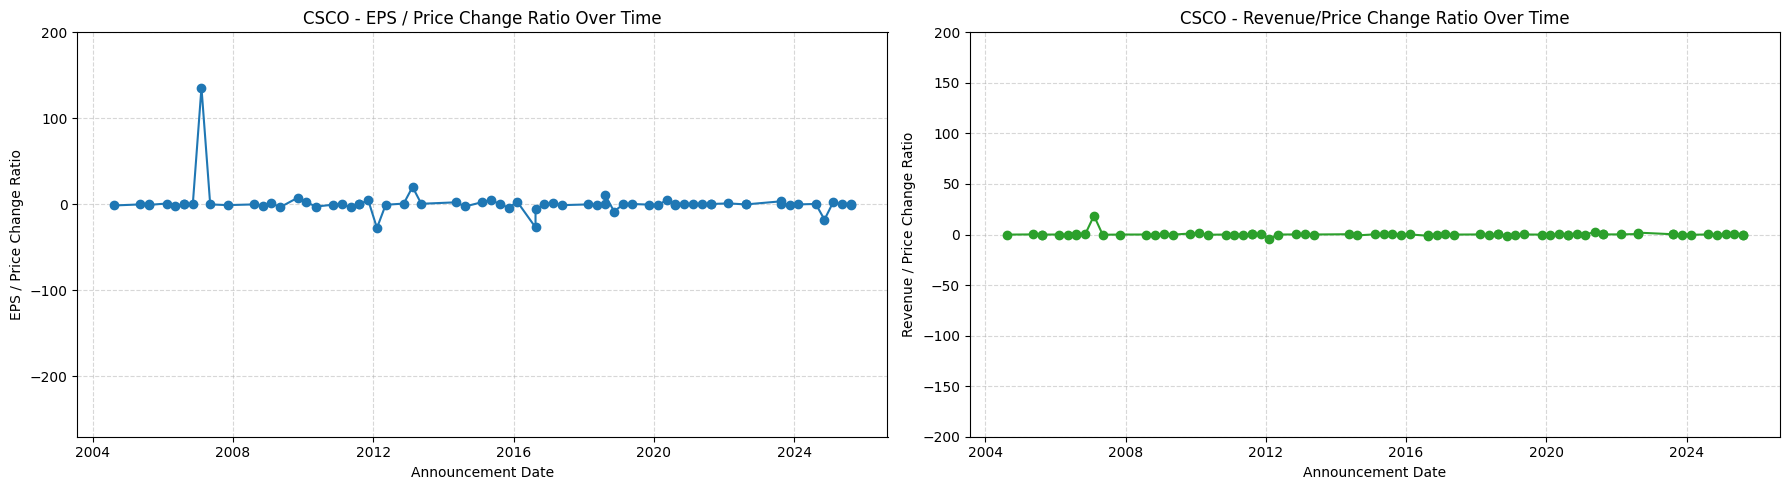

In [ ]:
def plot_ratio_surprise_vs_price_over_time(df):
    "Plot ratio of EPS/Price and Revenue/Price over time for each company. Fixed y-axis range -200 to 200."
    df = df.copy()
    df["Announce_Date"] = pd.to_datetime(df["Announce_Date"], errors="coerce")

    for tkr in df["Ticker"].unique():
        sub = df[df["Ticker"] == tkr].sort_values("Announce_Date").reset_index(drop=True)

        #Drop rows with missing or zero price change to avoid division by zero
        sub = sub.dropna(subset=["EPS_Surprise", "Revenue_Surprise", "PriceChange_%"])
        sub = sub[sub["PriceChange_%"] != 0]
        if len(sub) == 0:
            print(f"No valid data for {tkr}")
            continue

        #Compute ratios
        sub["EPS_to_Price_Ratio"] = sub["EPS_Surprise"] / sub["PriceChange_%"]
        sub["Revenue_to_Price_Ratio"] = sub["Revenue_Surprise"] / sub["PriceChange_%"]

        fig, axes = plt.subplots(1, 2, figsize=(18,5), sharex=True)

        #EPS/Price ratio
        axes[0].plot(sub["Announce_Date"], sub["EPS_to_Price_Ratio"], marker="o", color="tab:blue")
        axes[0].set_title(f"{tkr} - EPS / Price Change Ratio Over Time")
        axes[0].set_xlabel("Announcement Date")
        axes[0].set_ylabel("EPS / Price Change Ratio")
        axes[0].set_ylim(-270, 200)
        axes[0].grid(True, linestyle="--", alpha=0.5)

        #Revenue/Price ratio
        axes[1].plot(sub["Announce_Date"], sub["Revenue_to_Price_Ratio"], marker="o", color="tab:green")
        axes[1].set_title(f"{tkr} - Revenue/Price Change Ratio Over Time")
        axes[1].set_xlabel("Announcement Date")
        axes[1].set_ylabel("Revenue / Price Change Ratio")
        axes[1].set_ylim(-200, 200)
        axes[1].grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()

#Run for all companies
plot_ratio_surprise_vs_price_over_time(merged_with_prices)

CSCO - Matched EPS rows: 34, Matched Revenue rows: 34
CSCO -> EPS corr=0.032, slope=0.0065
CSCO -> Revenue corr=-0.136, slope=-0.0004


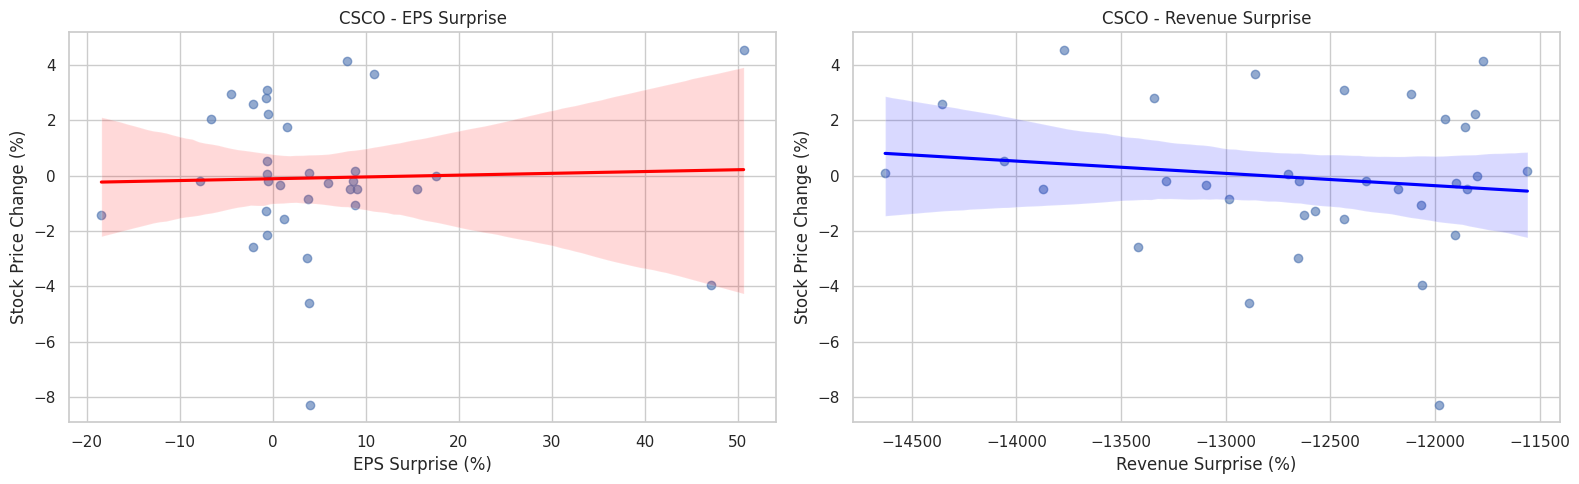

CSCO: Stronger correlation -> Revenue
XOM - Matched EPS rows: 53, Matched Revenue rows: 55
XOM -> EPS corr=0.079, slope=0.0128
XOM -> Revenue corr=0.263, slope=0.0000


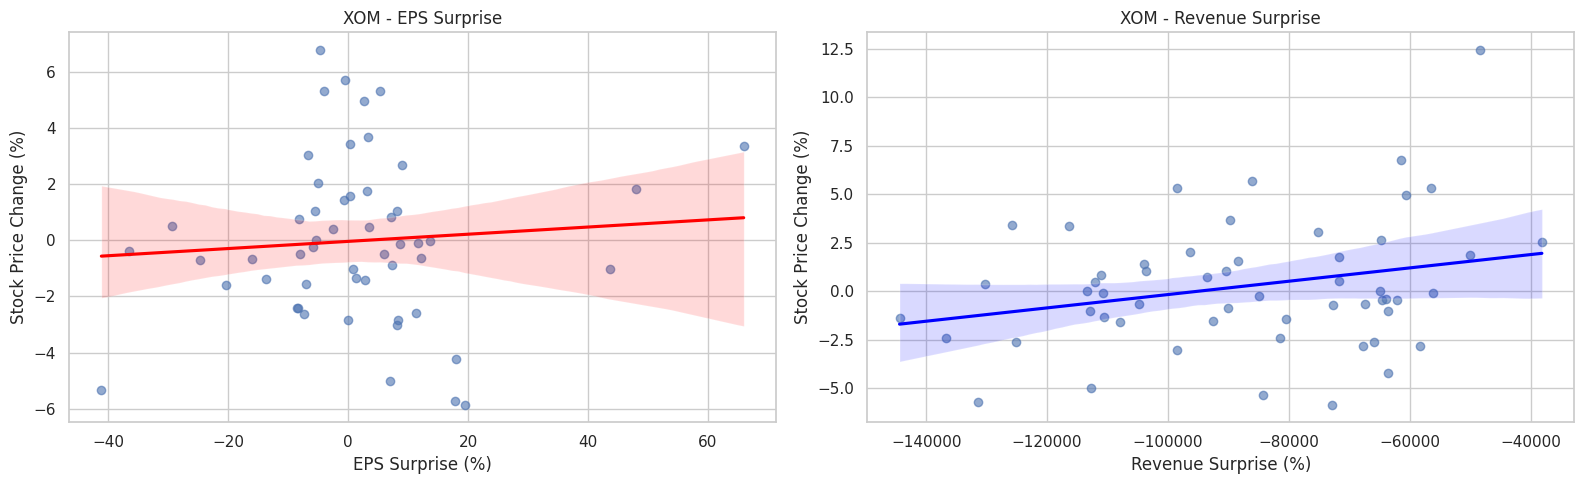

XOM: Stronger correlation -> Revenue
GS - Matched EPS rows: 47, Matched Revenue rows: 46
GS -> EPS corr=0.080, slope=0.0134
GS -> Revenue corr=-0.145, slope=-0.0003


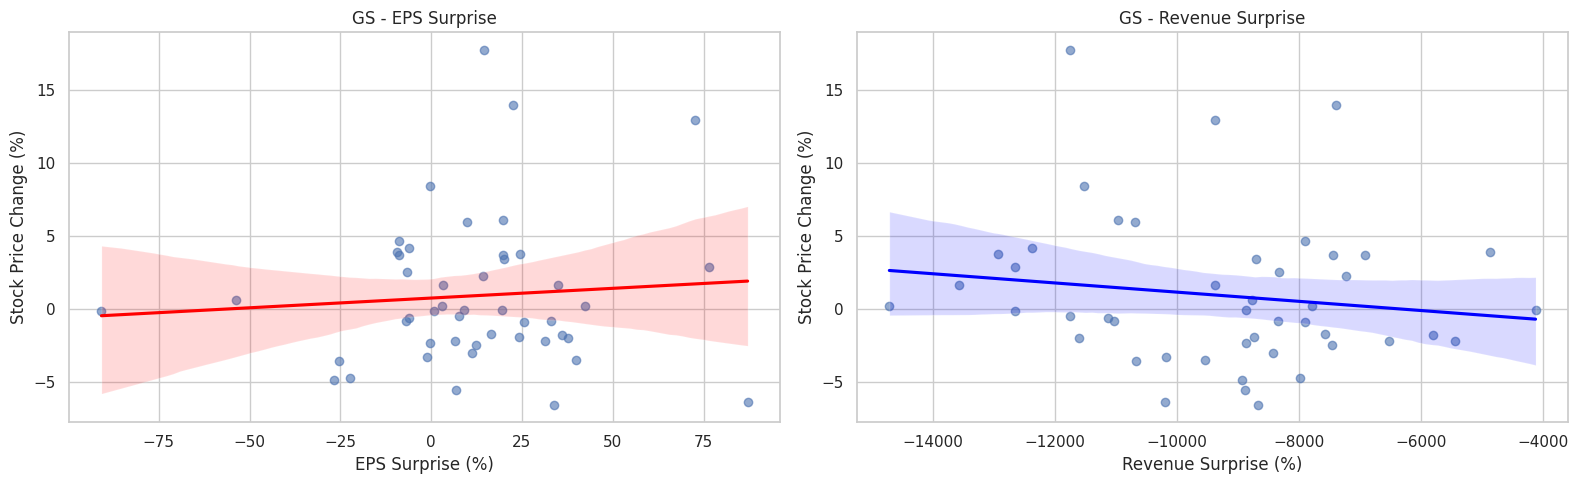

GS: Stronger correlation -> Revenue


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Simple number conversion
def simple_clean_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.startswith("(") and s.endswith(")"):
        s = "-" + s[1:-1]
    s = s.replace('%','').replace(',','')
    s = s.split()[0]
    try:
        return float(s)
    except:
        return np.nan


# Correlation and slope
def corr_and_slope(x, y):
    if len(x) < 2:
        return np.nan, np.nan
    r = np.corrcoef(x, y)[0,1]
    slope, intercept = np.polyfit(x, y, 1)
    return r, slope


# Main function: compute EPS/Revenue surprise and plot

def analyze_ticker_surprise(ticker_symbol, quarterly_df, result_df, days_tolerance=7):
    """
    ticker_symbol : str
    quarterly_df : pd.DataFrame (quarterly data for company)
    result_df : pd.DataFrame (filing data including PriceChange_%)
    days_tolerance : int
    """

    # Prepare filing summary

    df_filing = result_df.copy()
    df_filing['Filing Date'] = pd.to_datetime(df_filing['Filing Date'], errors='coerce')
    df_filing['PriceChange_num'] = df_filing['PriceChange_%'].apply(simple_clean_number)
    df_filing = df_filing[df_filing['Ticker'].str.upper() == ticker_symbol.upper()]
    df_filing = df_filing.dropna(subset=['Filing Date','PriceChange_num']).sort_values('Filing Date').reset_index(drop=True)

    if df_filing.empty:
        print(f"No filings with price change found for {ticker_symbol}.")
        return


    # Compute EPS and Revenue surprise

    df = quarterly_df.copy()

    #  dates are datetime
    df['EPS Announced Date'] = pd.to_datetime(df['EPS Announced Date'], errors='coerce')
    df['Revenue Announced Date'] = pd.to_datetime(df['Revenue Announced Date'], errors='coerce')

    # calc surprises
    df['EPS_Surprise'] = df.apply(lambda row: simple_clean_number(row['EPS (GAAP)']) - simple_clean_number(row['EPS Estimate']), axis=1)
    df['REV_Surprise'] = df.apply(lambda row: simple_clean_number(row['Revenue']) - simple_clean_number(row['Revenue Estimate']), axis=1)

    # EPS table

    eps_tbl = df[['EPS_Surprise', 'EPS Announced Date']].rename(columns={'EPS Announced Date': 'AnnouncedDate'})
    eps_tbl = eps_tbl.dropna(subset=['EPS_Surprise','AnnouncedDate']).sort_values('AnnouncedDate')

    # Revenue table
    rev_tbl = df[['REV_Surprise', 'Revenue Announced Date']].rename(columns={'Revenue Announced Date': 'AnnouncedDate'})
    rev_tbl = rev_tbl.dropna(subset=['REV_Surprise','AnnouncedDate']).sort_values('AnnouncedDate')


    # Merge filings to nearest announcement date

    eps_merged = pd.merge_asof(
        df_filing.sort_values('Filing Date'),
        eps_tbl.sort_values('AnnouncedDate'),
        left_on='Filing Date',
        right_on='AnnouncedDate',
        direction='nearest',
        tolerance=pd.Timedelta(days=days_tolerance)
    )

    rev_merged = pd.merge_asof(
        df_filing.sort_values('Filing Date'),
        rev_tbl.sort_values('AnnouncedDate'),
        left_on='Filing Date',
        right_on='AnnouncedDate',
        direction='nearest',
        tolerance=pd.Timedelta(days=days_tolerance)
    )

    # Keep matched rows
    eps_pair = eps_merged[['PriceChange_num','EPS_Surprise']].dropna()
    rev_pair = rev_merged[['PriceChange_num','REV_Surprise']].dropna()

    print(f"{ticker_symbol} - Matched EPS rows: {len(eps_pair)}, Matched Revenue rows: {len(rev_pair)}")


    # calc correlation
    eps_r, eps_slope = corr_and_slope(eps_pair['EPS_Surprise'].values, eps_pair['PriceChange_num'].values)
    rev_r, rev_slope = corr_and_slope(rev_pair['REV_Surprise'].values, rev_pair['PriceChange_num'].values)

    print(f"{ticker_symbol} -> EPS corr={eps_r:.3f}, slope={eps_slope:.4f}")
    print(f"{ticker_symbol} -> Revenue corr={rev_r:.3f}, slope={rev_slope:.4f}")


    # Side-by-side plots

    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16,5))

    # EPS plot
    if not eps_pair.empty:
        sns.regplot(x='EPS_Surprise', y='PriceChange_num', data=eps_pair,
                    scatter_kws={'alpha':0.6}, line_kws={'color':'red'},
                    ax=axes[0])
    axes[0].set_xlabel('EPS Surprise (%)')
    axes[0].set_ylabel('Stock Price Change (%)')
    axes[0].set_title(f'{ticker_symbol} - EPS Surprise')

    # Revenue plot
    if not rev_pair.empty:
        sns.regplot(x='REV_Surprise', y='PriceChange_num', data=rev_pair,
                    scatter_kws={'alpha':0.6}, line_kws={'color':'blue'},
                    ax=axes[1])
    axes[1].set_xlabel('Revenue Surprise (%)')
    axes[1].set_ylabel('Stock Price Change (%)')
    axes[1].set_title(f'{ticker_symbol} - Revenue Surprise')

    plt.tight_layout()
    plt.show()


    # Stronger correlation

    if np.isnan(eps_r) and np.isnan(rev_r):
        print(f"{ticker_symbol}: Not enough matched data to compare EPS vs Revenue.")
    else:
        stronger = "EPS" if abs(eps_r if not np.isnan(eps_r) else 0) > abs(rev_r if not np.isnan(rev_r) else 0) else "Revenue"
        print(f"{ticker_symbol}: Stronger correlation -> {stronger}")


# Example

analyze_ticker_surprise('CSCO', CSCO_quarterly_df, result_df)       # Default 7-day tolerance
analyze_ticker_surprise('XOM', XOM_quarterly_df, result_df)         # Default 7-day tolerance
analyze_ticker_surprise('GS', GS_quarterly_df, result_df, days_tolerance=21)  # Extended to 21 days


CSCO: Data found with 7-day tolerance for EPS (122 rows) and Revenue (122 rows)


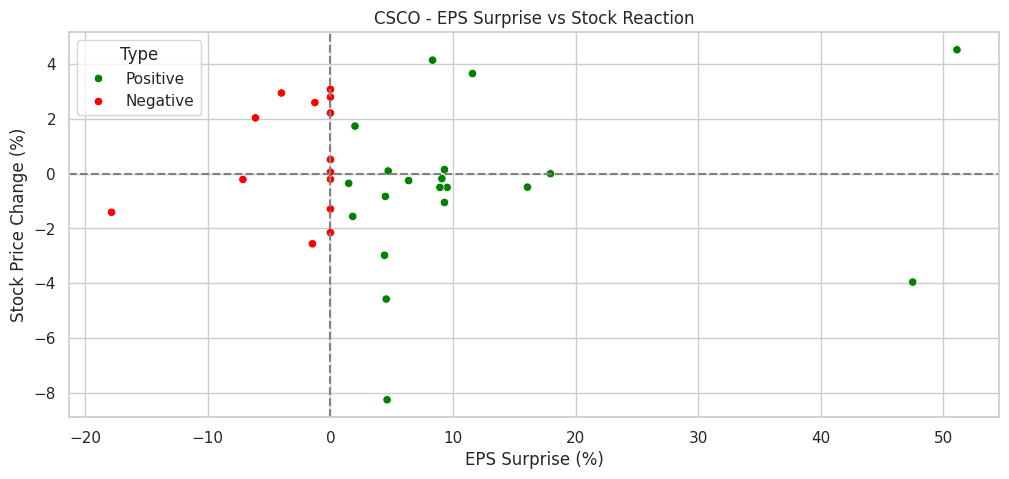

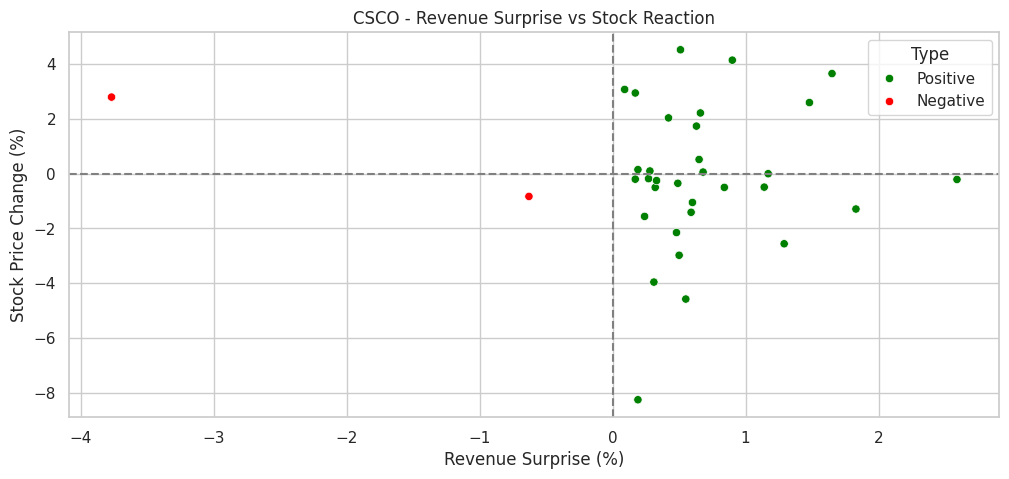

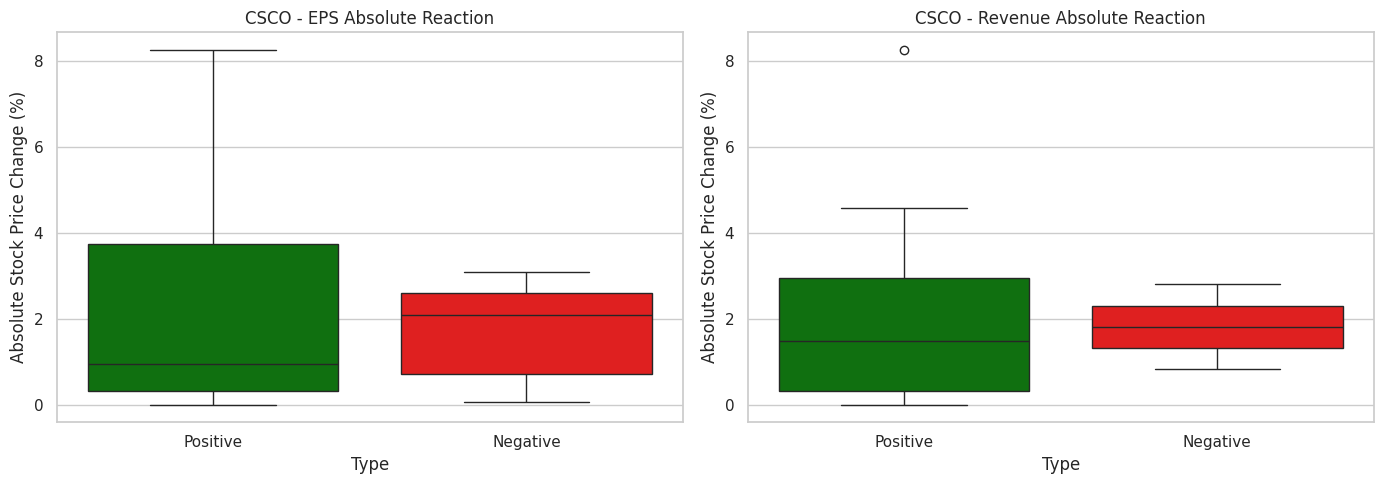

GS: Data found with 21-day tolerance for EPS (103 rows) and Revenue (103 rows)


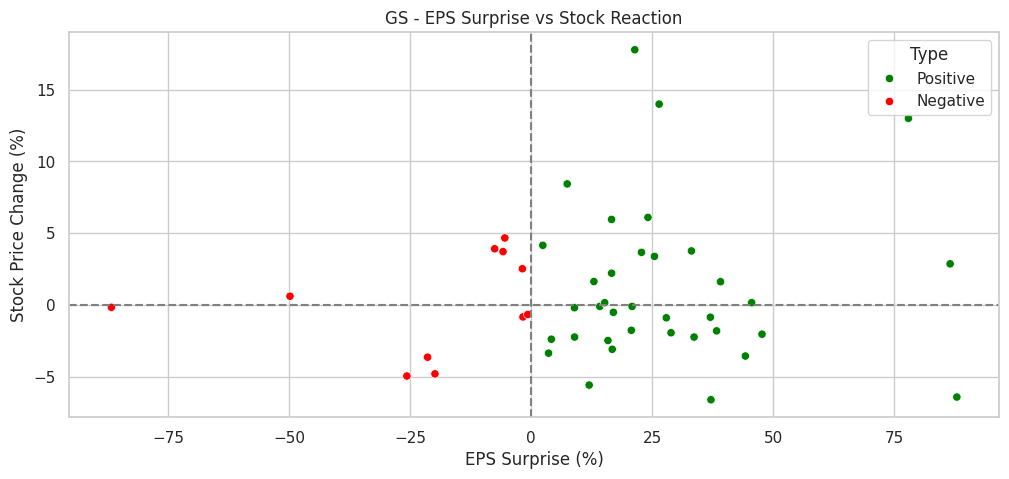

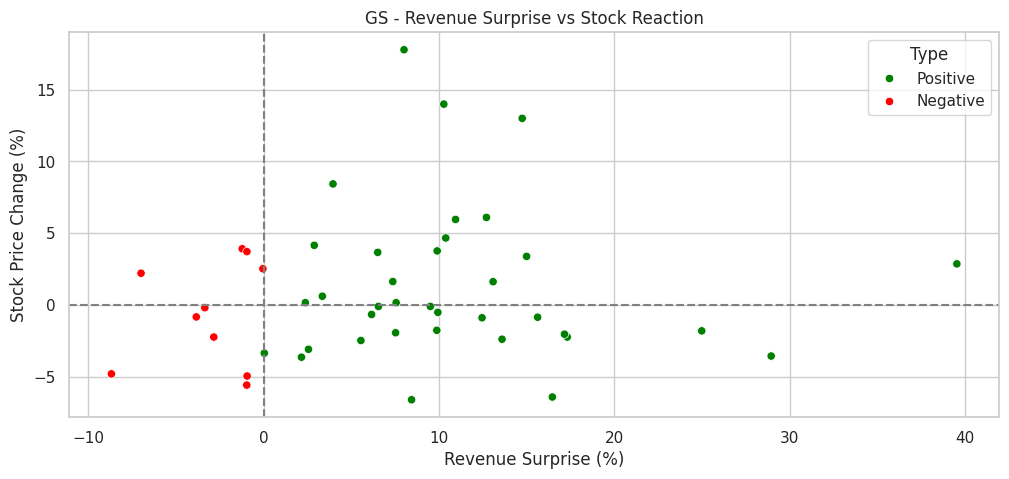

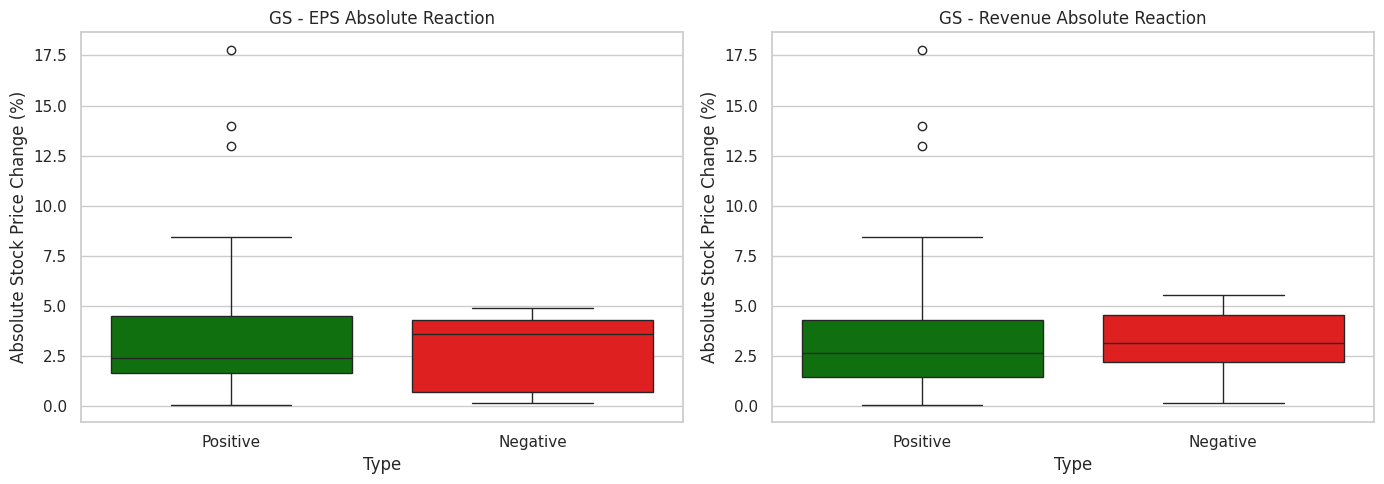

XOM: Data found with 7-day tolerance for EPS (125 rows) and Revenue (125 rows)


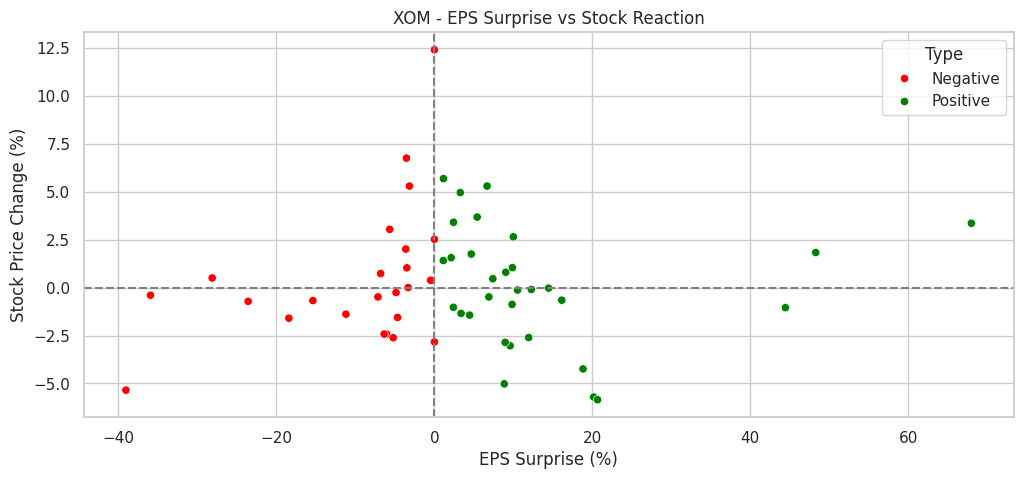

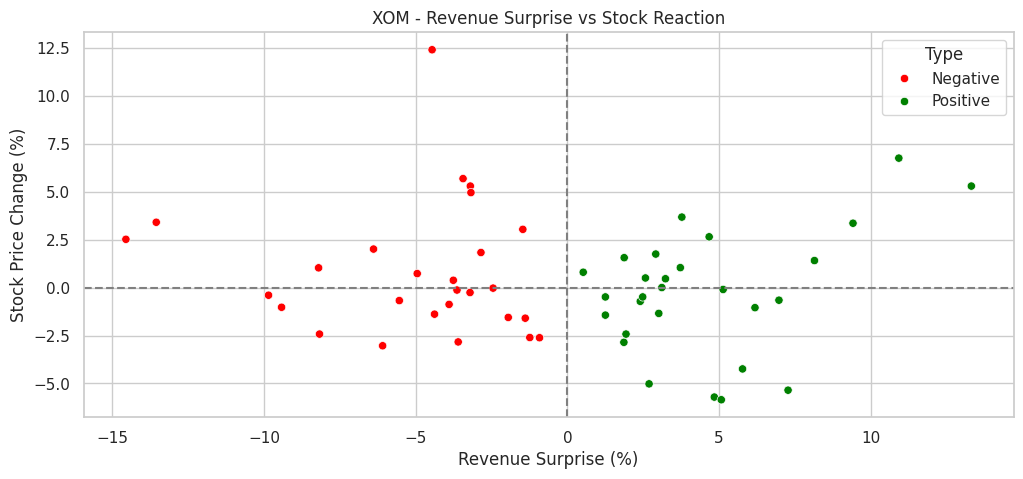

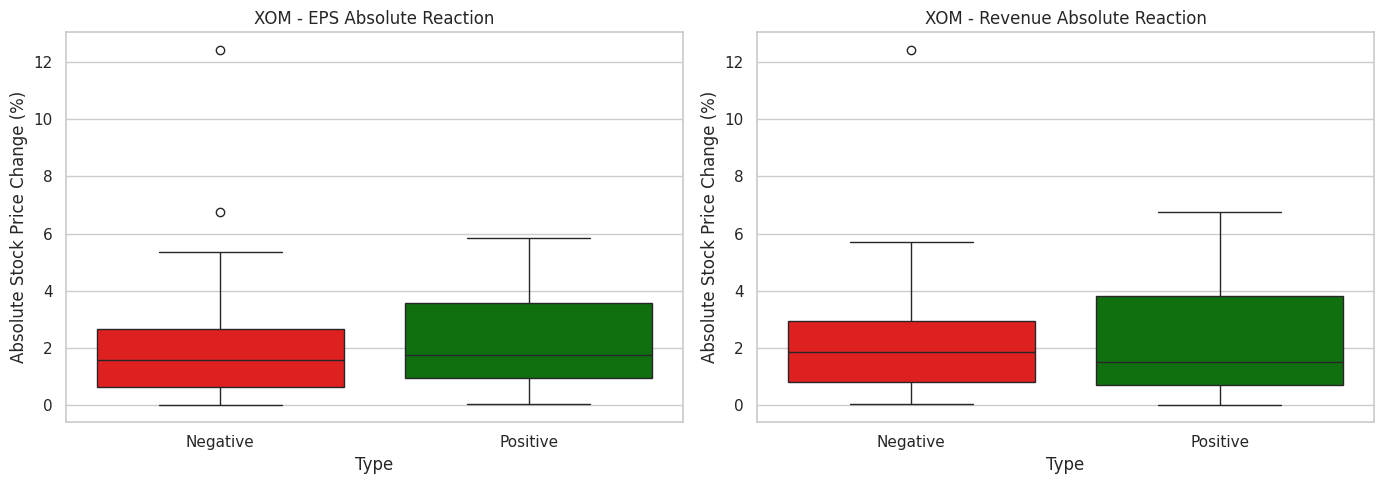

In [ ]:
# Clean percent
def simple_clean_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.startswith('(') and s.endswith(')'):
        s = '-' + s[1:-1]
    s = s.replace('%', '').replace(',', '')
    try:
        return float(s)
    except:
        return np.nan

# Merge filings
def merge_with_price(result_df, quarterly_df, ticker):
    filings = result_df[result_df['Ticker'].str.upper() == ticker.upper()].copy()
    filings['Filing Date'] = pd.to_datetime(filings['Filing Date'], errors='coerce')
    filings['PriceChange_num'] = filings['PriceChange_%'].apply(simple_clean_number)

    quarterly_df = quarterly_df.copy()
    quarterly_df['EPS Announced Date'] = pd.to_datetime(quarterly_df['EPS Announced Date'], errors='coerce')
    quarterly_df['Revenue Announced Date'] = pd.to_datetime(quarterly_df['Revenue Announced Date'], errors='coerce')

    # fix toleranc because GS has filled stock price data on later date
    tolerance_days = 21 if ticker.upper() == "GS" else 7

    eps_tbl = quarterly_df[['EPS (GAAP)', 'EPS Announced Date']].rename(
        columns={'EPS (GAAP)': 'EPS_Surprise', 'EPS Announced Date': 'AnnouncedDate'}
    )
    eps_tbl['EPS_Surprise'] = eps_tbl['EPS_Surprise'].apply(simple_clean_number)
    eps_tbl = eps_tbl.dropna(subset=['EPS_Surprise', 'AnnouncedDate'])

    eps_merged = pd.merge_asof(
        filings.sort_values('Filing Date'),
        eps_tbl.sort_values('AnnouncedDate'),
        left_on='Filing Date',
        right_on='AnnouncedDate',
        direction='nearest',
        tolerance=pd.Timedelta(days=tolerance_days)
    )

    rev_tbl = quarterly_df[['Revenue', 'Revenue Announced Date']].rename(
        columns={'Revenue': 'REV_Surprise', 'Revenue Announced Date': 'AnnouncedDate'}
    )
    rev_tbl['REV_Surprise'] = rev_tbl['REV_Surprise'].apply(simple_clean_number)
    rev_tbl = rev_tbl.dropna(subset=['REV_Surprise', 'AnnouncedDate'])

    rev_merged = pd.merge_asof(
        filings.sort_values('Filing Date'),
        rev_tbl.sort_values('AnnouncedDate'),
        left_on='Filing Date',
        right_on='AnnouncedDate',
        direction='nearest',
        tolerance=pd.Timedelta(days=tolerance_days)
    )

    print(f"{ticker}: Data found with {tolerance_days}-day tolerance for EPS ({len(eps_merged)} rows) and Revenue ({len(rev_merged)} rows)")
    return eps_merged, rev_merged


# Minimal plotting function

def plot_asymmetric_reaction(ticker, quarterly_df, result_df):
    eps_merged, rev_merged = merge_with_price(result_df, quarterly_df, ticker)

    eps_data = eps_merged[['PriceChange_num', 'EPS_Surprise']].dropna()
    eps_data['Type'] = eps_data['EPS_Surprise'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

    rev_data = rev_merged[['PriceChange_num', 'REV_Surprise']].dropna()
    rev_data['Type'] = rev_data['REV_Surprise'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

    # Scatter plots
    plt.figure(figsize=(12, 5))
    sns.scatterplot(
        data=eps_data,
        x='EPS_Surprise',
        y='PriceChange_num',
        hue='Type',
        palette={'Positive': 'green', 'Negative': 'red'}
    )
    plt.axvline(0, color='gray', linestyle='--')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('EPS Surprise (%)')
    plt.ylabel('Stock Price Change (%)')
    plt.title(f'{ticker} - EPS Surprise vs Stock Reaction')
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.scatterplot(
        data=rev_data,
        x='REV_Surprise',
        y='PriceChange_num',
        hue='Type',
        palette={'Positive': 'green', 'Negative': 'red'}
    )
    plt.axvline(0, color='gray', linestyle='--')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Revenue Surprise (%)')
    plt.ylabel('Stock Price Change (%)')
    plt.title(f'{ticker} - Revenue Surprise vs Stock Reaction')
    plt.show()

    # Boxplots : absolute reactios
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(
        data=eps_data,
        x='Type',
        y=eps_data['PriceChange_num'].abs(),
        hue='Type',
        palette={'Positive': 'green', 'Negative': 'red'},
        legend=False,
        ax=axes[0]
    )
    axes[0].set_ylabel('Absolute Stock Price Change (%)')
    axes[0].set_title(f'{ticker} - EPS Absolute Reaction')

    sns.boxplot(
        data=rev_data,
        x='Type',
        y=rev_data['PriceChange_num'].abs(),
        hue='Type',
        palette={'Positive': 'green', 'Negative': 'red'},
        legend=False,
        ax=axes[1]
    )
    axes[1].set_ylabel('Absolute Stock Price Change (%)')
    axes[1].set_title(f'{ticker} - Revenue Absolute Reaction')

    plt.tight_layout()
    plt.show()


plot_asymmetric_reaction('CSCO', CSCO_quarterly_df, result_df)
plot_asymmetric_reaction('GS', GS_quarterly_df, result_df)
plot_asymmetric_reaction('XOM', XOM_quarterly_df, result_df)


CSCO: EPS matched rows = 34 (source=quarterly, tol=7) | REV matched rows = 34 (source=quarterly, tol=7)


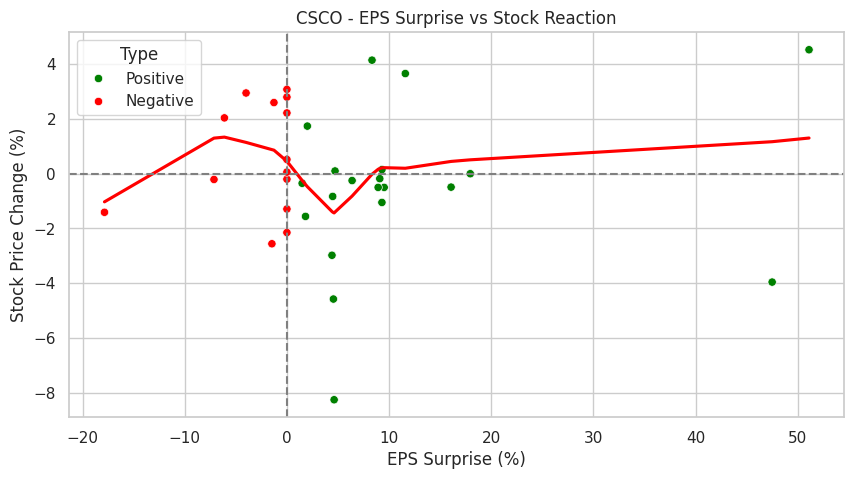

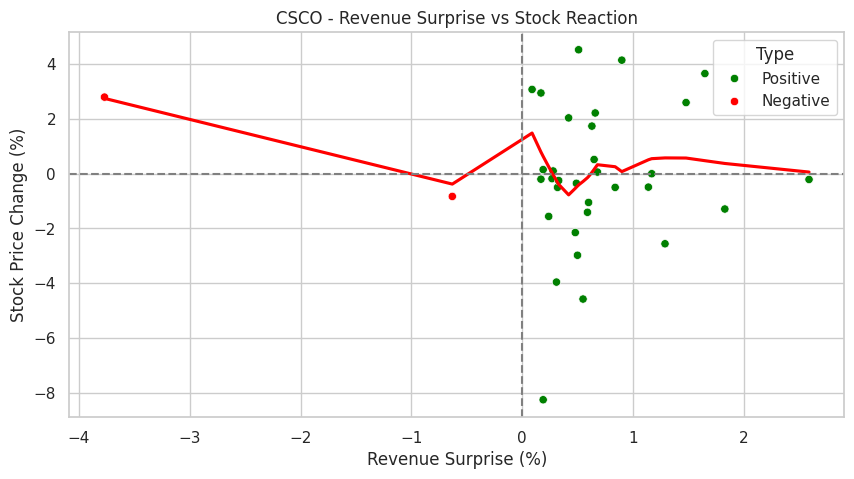

GS: EPS matched rows = 47 (source=quarterly, tol=21) | REV matched rows = 46 (source=quarterly, tol=21)


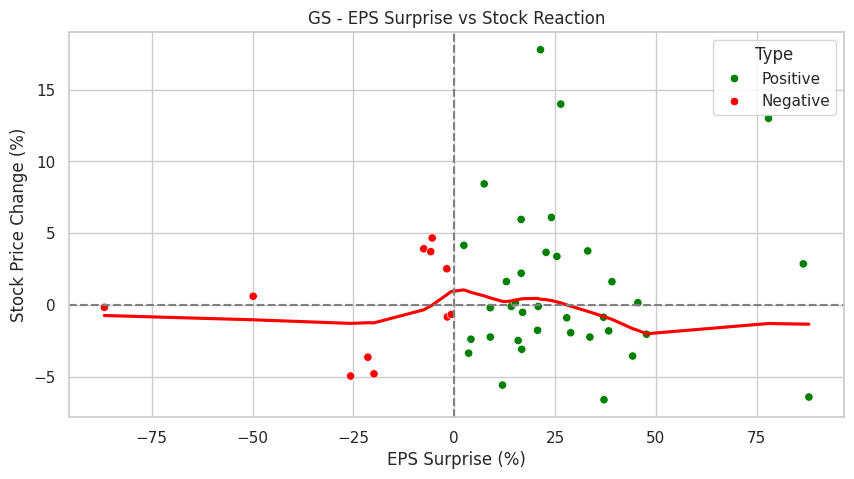

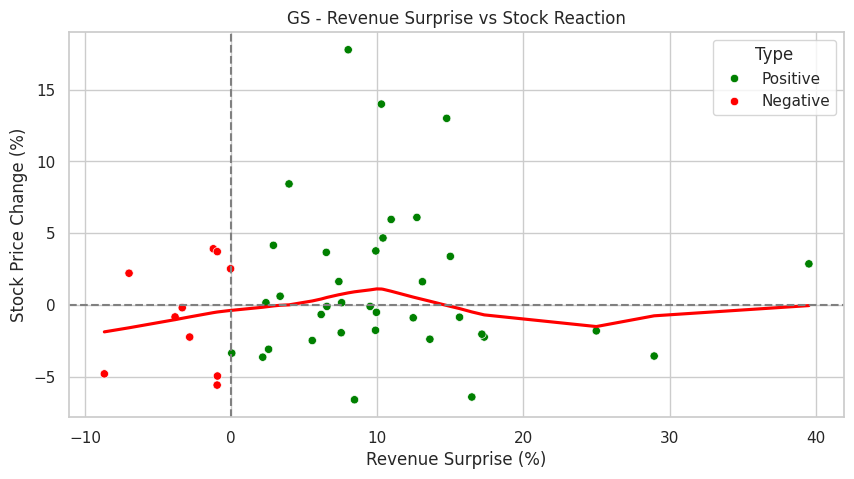

XOM: EPS matched rows = 55 (source=quarterly, tol=7) | REV matched rows = 55 (source=quarterly, tol=7)


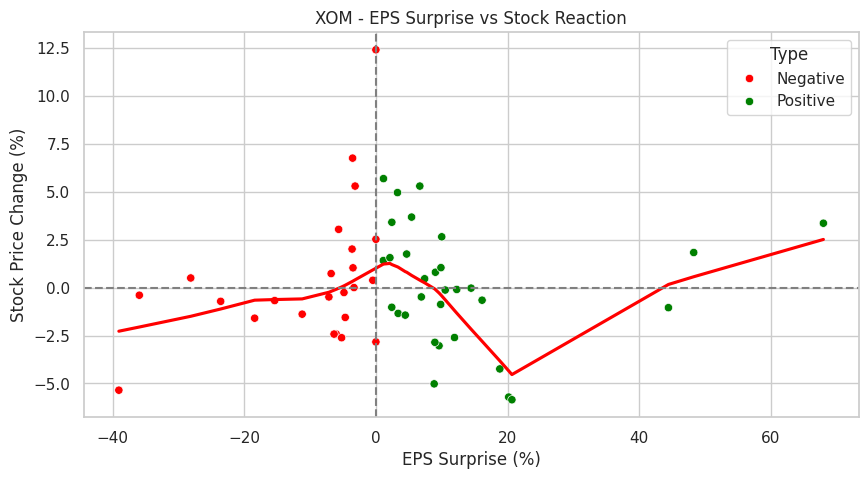

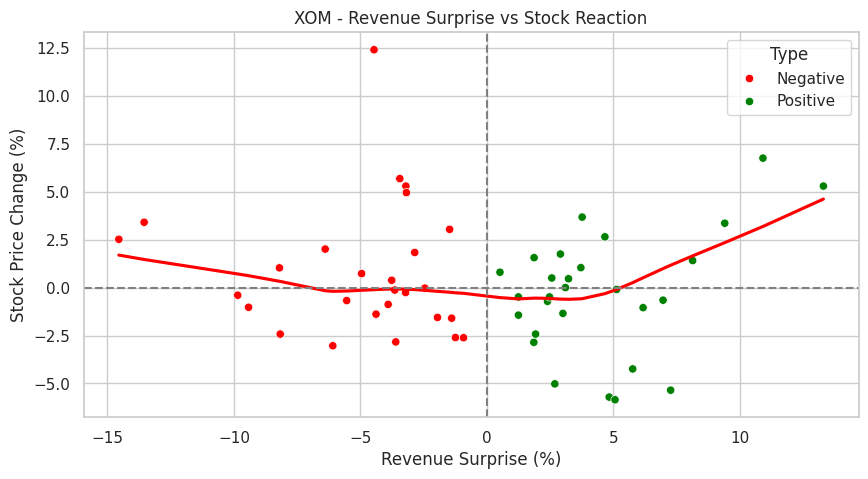

In [ ]:
sns.set_style("whitegrid")

#Cleaner numbers

def simple_clean_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.startswith('(') and s.endswith(')'):
        s = '-' + s[1:-1]
    s = s.replace('%', '').replace(',', '')
    try:
        return float(s)
    except:
        return np.nan



# surprise table
def prepare_table(df, val_col, date_col, new_col):
    df2 = df.copy()
    # make sure the date col exists
    if date_col not in df2.columns or val_col not in df2.columns:
        return pd.DataFrame(columns=[new_col, "AnnouncedDate"])
    df2[date_col] = pd.to_datetime(df2[date_col], errors="coerce")
    tbl = df2[[val_col, date_col]].rename(columns={val_col: new_col, date_col: "AnnouncedDate"})
    tbl[new_col] = tbl[new_col].apply(simple_clean_number)
    tbl = tbl.dropna(subset=[new_col, "AnnouncedDate"]).sort_values("AnnouncedDate")
    return tbl


#  merging filings with a table
def try_merge(filings, tbl, tol_days):
    if tbl.empty or filings.empty:
        return pd.DataFrame(), False
    merged = pd.merge_asof(
        filings.sort_values("Filing Date"),
        tbl,
        left_on="Filing Date",
        right_on="AnnouncedDate",
        direction="nearest",
        tolerance=pd.Timedelta(days=tol_days)
    )
    # rows where the announced value matched will have the new_col non-null
    matched = merged.dropna(subset=[c for c in tbl.columns if c != "AnnouncedDate"], how='all')
    return merged, not matched.empty


# try quarterly first then fallback to yearly
def merge_with_fallback(result_df, quarterly_df, yearly_df, ticker,
                        tol_quarterly=7, tol_yearly=21):
    filings = result_df[result_df["Ticker"].str.upper() == ticker.upper()].copy()
    if filings.empty:
        print(f"{ticker}: no filings found in result_df")
        return pd.DataFrame(), pd.DataFrame()

    filings["Filing Date"] = pd.to_datetime(filings["Filing Date"], errors="coerce")
    filings = filings.dropna(subset=["Filing Date"]).sort_values("Filing Date")
    filings["PriceChange_num"] = filings["PriceChange_%"].apply(simple_clean_number)

    # Build tables from quarterly and yearly data
    eps_q = prepare_table(quarterly_df, "EPS (GAAP)", "EPS Announced Date", "EPS_Surprise")
    rev_q = prepare_table(quarterly_df, "Revenue", "Revenue Announced Date", "Revenue_Surprise")

    eps_y = prepare_table(yearly_df, "EPS (GAAP)", "EPS Announced Date", "EPS_Surprise")
    rev_y = prepare_table(yearly_df, "Revenue", "Revenue Announced Date", "Revenue_Surprise")

    # adjust tolerances for GS special case
    if ticker.upper() == "GS":
        tol_q = max(tol_quarterly, 21)
        tol_y = max(tol_yearly, 21)
    else:
        tol_q = tol_quarterly
        tol_y = tol_yearly

    # Try quarterly EPSs else yearly EPS
    eps_merged_q, eps_q_found = try_merge(filings, eps_q, tol_q)
    if eps_q_found:
        eps_merged = eps_merged_q
        eps_source = "quarterly"
        eps_tol_used = tol_q
    else:
        eps_merged_y, eps_y_found = try_merge(filings, eps_y, tol_y)
        eps_merged = eps_merged_y
        eps_source = "yearly" if eps_y_found else None
        eps_tol_used = tol_y

    # Try quarterly REv else yearly REV
    rev_merged_q, rev_q_found = try_merge(filings, rev_q, tol_q)
    if rev_q_found:
        rev_merged = rev_merged_q
        rev_source = "quarterly"
        rev_tol_used = tol_q
    else:
        rev_merged_y, rev_y_found = try_merge(filings, rev_y, tol_y)
        rev_merged = rev_merged_y
        rev_source = "yearly" if rev_y_found else None
        rev_tol_used = tol_y

    #
    eps_rows = 0 if eps_merged.empty else eps_merged.dropna(subset=["EPS_Surprise"]).shape[0]
    rev_rows = 0 if rev_merged.empty else rev_merged.dropna(subset=["Revenue_Surprise"]).shape[0]
    print(f"{ticker}: EPS matched rows = {eps_rows} (source={eps_source}, tol={eps_tol_used}) | "
          f"REV matched rows = {rev_rows} (source={rev_source}, tol={rev_tol_used})")

    # Return both merged frames
    return eps_merged, rev_merged


# Plot helper
def plot_asymmetric_reaction_unified(ticker, quarterly_df, yearly_df, result_df):
    eps_merged, rev_merged = merge_with_fallback(result_df, quarterly_df, yearly_df, ticker)

    # Create plotting datasets both surprise and pricechange numeric
    eps_plot = eps_merged[['PriceChange_num', 'EPS_Surprise']].copy() if not eps_merged.empty else pd.DataFrame()
    rev_plot = rev_merged[['PriceChange_num', 'Revenue_Surprise']].copy() if not rev_merged.empty else pd.DataFrame()

    # Clean numeric columns
    if not eps_plot.empty:
        eps_plot['PriceChange_num'] = eps_plot['PriceChange_num'].apply(simple_clean_number)
        eps_plot['EPS_Surprise'] = eps_plot['EPS_Surprise'].apply(simple_clean_number)
        eps_plot = eps_plot.dropna(subset=['PriceChange_num', 'EPS_Surprise'])

    if not rev_plot.empty:
        rev_plot['PriceChange_num'] = rev_plot['PriceChange_num'].apply(simple_clean_number)
        rev_plot['Revenue_Surprise'] = rev_plot['Revenue_Surprise'].apply(simple_clean_number)
        rev_plot = rev_plot.dropna(subset=['PriceChange_num', 'Revenue_Surprise'])

    # Plot EPS
    if not eps_plot.empty:
        eps_plot['Type'] = eps_plot['EPS_Surprise'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
        plt.figure(figsize=(10,5))
        sns.scatterplot(data=eps_plot, x='EPS_Surprise', y='PriceChange_num', hue='Type',
                        palette={'Positive': 'green', 'Negative': 'red'})
        sns.regplot(data=eps_plot, x='EPS_Surprise', y='PriceChange_num', scatter=False, lowess=True, line_kws={'color':'red'})
        plt.axvline(0, color='gray', linestyle='--')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title(f"{ticker} - EPS Surprise vs Stock Reaction")
        plt.xlabel("EPS Surprise (%)")
        plt.ylabel("Stock Price Change (%)")
        plt.show()
    else:
        print(f"{ticker} - EPS: No matched numeric rows to plot")

    # Plot Revenue
    if not rev_plot.empty:
        rev_plot['Type'] = rev_plot['Revenue_Surprise'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
        plt.figure(figsize=(10,5))
        sns.scatterplot(data=rev_plot, x='Revenue_Surprise', y='PriceChange_num', hue='Type',
                        palette={'Positive': 'green', 'Negative': 'red'})
        sns.regplot(data=rev_plot, x='Revenue_Surprise', y='PriceChange_num', scatter=False, lowess=True, line_kws={'color':'red'})
        plt.axvline(0, color='gray', linestyle='--')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title(f"{ticker} - Revenue Surprise vs Stock Reaction")
        plt.xlabel("Revenue Surprise (%)")
        plt.ylabel("Stock Price Change (%)")
        plt.show()
    else:
        print(f"{ticker} - Revenue: No matched numeric rows to plot")


#  run for all three (use quarterly first, yearly fallback)
plot_asymmetric_reaction_unified('CSCO', CSCO_quarterly_df, CSCO_yearly_df, result_df)
plot_asymmetric_reaction_unified('GS', GS_quarterly_df, GS_yearly_df, result_df)
plot_asymmetric_reaction_unified('XOM', XOM_quarterly_df, XOM_yearly_df, result_df)
